In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.model_selection

import tensorflow as tf

# tf.config.threading.set_inter_op_parallelism_threads(2)

from tensorflow import keras
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras import backend as K

## Loading Train and Test Data

In [2]:
data_dir = Path("../input/digit-recognizer/")
train = pd.read_csv(data_dir / "train.csv")
test = pd.read_csv(data_dir / "test.csv")

In [3]:
X_train = (train.iloc[:,1:].values).astype('float32') # all pixel values
y_train = train.iloc[:,0].values.astype('int32') # only labels i.e targets digits
X_test = test.values.astype('float32')

In [4]:
# Convert train and test dataset to (num_images, img_rows, img_cols) format 
x_train = X_train.reshape(X_train.shape[0], 28, 28,1)
x_test = X_test.reshape(X_test.shape[0], 28, 28,1)

In [5]:
# Values of labels
class_names = list(set(y_train))
class_names

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

## Sample Data Visualization

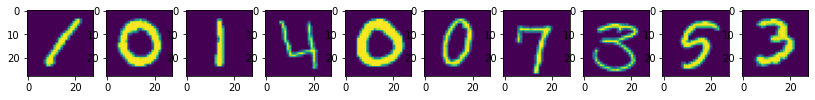

In [6]:
plt.figure(figsize=(14,14))
x, y = 10, 4 
for i in range(10):  
    plt.subplot(y, x, i+1)
    plt.imshow(x_train[i])
plt.show()

## Training Parameters

In [7]:
batch_size = 64 # 128
num_classes = len(class_names) # 10
epochs = 15
w_l2 = 1e-5

In [8]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

## Preprocessing

In [9]:
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Converting class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)

x_train shape: (42000, 28, 28, 1)
42000 train samples
28000 test samples


In [10]:
# Train and Validation Data
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(x_train, y_train, train_size=0.8)

## Model

In [11]:
model = Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3),  kernel_regularizer=tf.keras.regularizers.l2(w_l2),
                 input_shape=input_shape))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Conv2D(64, (3, 3),  kernel_regularizer=tf.keras.regularizers.l2(w_l2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(w_l2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 24, 24, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0

2022-11-01 17:55:44.691483: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 17:55:44.800042: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 17:55:44.800866: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 17:55:44.802320: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
history1=model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val), callbacks=[reduce_lr])
score = model.evaluate(X_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2022-11-01 17:55:47.585696: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2022-11-01 17:55:49.211914: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


525/525 [==============================] - 10s 6ms/step - loss: 0.2189 - accuracy: 0.9400 - val_loss: 0.2002 - val_accuracy: 0.9417
Epoch 2/15
525/525 [==============================] - 3s 5ms/step - loss: 0.0968 - accuracy: 0.9741 - val_loss: 0.0533 - val_accuracy: 0.9864
Epoch 3/15
525/525 [==============================] - 3s 5ms/step - loss: 0.0756 - accuracy: 0.9796 - val_loss: 0.0639 - val_accuracy: 0.9839
Epoch 4/15
525/525 [==============================] - 3s 5ms/step - loss: 0.0627 - accuracy: 0.9839 - val_loss: 0.0487 - val_accuracy: 0.9885
Epoch 5/15
525/525 [==============================] - 3s 5ms/step - loss: 0.0599 - accuracy: 0.9857 - val_loss: 0.0537 - val_accuracy: 0.9887
Epoch 6/15
525/525 [==============================] - 3s 6ms/step - loss: 0.0569 - accuracy: 0.9857 - val_loss: 0.0634 - val_accuracy: 0.9844
Epoch 7/15
525/525 [==============================] - 3s 5ms/step - loss: 0.0549 - accuracy: 0.9880 - val_loss: 0.0562 - val_accuracy: 0.9887
Epoch 8/15
525/5

## Visualizing Evaluation

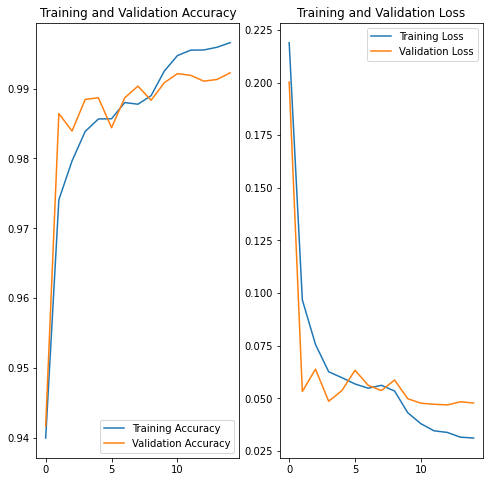

In [13]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, mode='auto'),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

history2 = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks,
          verbose=1,
          validation_data=(X_val, y_val))

Epoch 1/15
525/525 [==============================] - 3s 6ms/step - loss: 0.0299 - accuracy: 0.9963 - val_loss: 0.0450 - val_accuracy: 0.9915
Epoch 2/15
525/525 [==============================] - 3s 5ms/step - loss: 0.0278 - accuracy: 0.9975 - val_loss: 0.0450 - val_accuracy: 0.9924
Epoch 3/15
525/525 [==============================] - 3s 5ms/step - loss: 0.0261 - accuracy: 0.9979 - val_loss: 0.0464 - val_accuracy: 0.9925
Epoch 4/15
525/525 [==============================] - 3s 5ms/step - loss: 0.0259 - accuracy: 0.9975 - val_loss: 0.0456 - val_accuracy: 0.9917
Epoch 5/15
525/525 [==============================] - 3s 5ms/step - loss: 0.0258 - accuracy: 0.9975 - val_loss: 0.0459 - val_accuracy: 0.9918
Epoch 6/15
525/525 [==============================] - 3s 5ms/step - loss: 0.0260 - accuracy: 0.9972 - val_loss: 0.0467 - val_accuracy: 0.9923


In [15]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.04671083763241768
Test accuracy: 0.9922618865966797


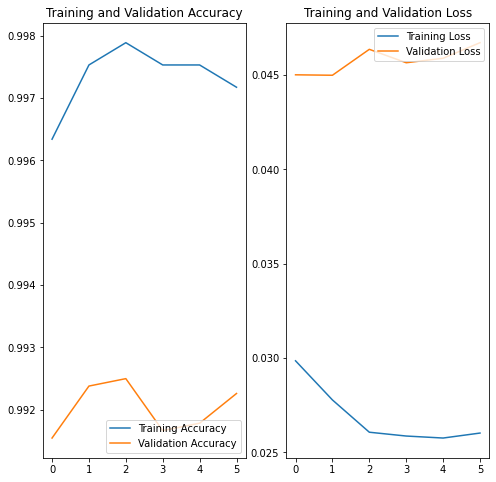

In [16]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(history2.epoch, acc, label='Training Accuracy')
plt.plot(history2.epoch, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history2.epoch, loss, label='Training Loss')
plt.plot(history2.epoch, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Prediction

In [17]:
predictions = model.predict(x_test)

In [18]:
labels = []
for pre in predictions:
    score = tf.nn.softmax(pre)
    labels.append(class_names[np.argmax(score)])

In [19]:
# Submitting
output = pd.DataFrame({'ImageId': list(range(1,len(labels)+1)), 'Label': labels})
output.to_csv('submission.csv', index=False, header=True)
print("Submission saved!")

Submission saved!
